In [49]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
from matplotlib import pyplot as plt
import csv
from scipy.stats import norm, binom 
from scipy import linalg
import random
from decimal import Decimal
import pydtmc
from collections import Counter
import quantecon as qe
from mpl_toolkits.mplot3d import Axes3D
from tqdm.auto import tqdm

In [50]:
def pSS(nL, nC): #Gets probability of lobbying successfully, subjective
    return 1 - ((.8+nC) / (1+nL))

In [51]:
def pCat2(nL, R):  #Gets objective probability of success 
    if nL <= R:
        return .8
    else:
        return .8 * (R / nL)

In [52]:
def pL(nL, nC, LC, mF, T): ## Calculates subjective probability of lobbying
    ps = pSS(nL, nC)
    temp = (-LC + (ps*T))/((1-ps)) ## value that the normal distrobution draw need to be less then to choose to lobby
    return norm(loc = mF, scale = 1).cdf(temp) ## probability of lobbying for individual

In [53]:
def getTM(LC, T, mF, nPPL, fR):

    R = nPPL * fR
    
    lis = []
    for i in range(0,nPPL+1):
        for r in range(0,nPPL+1):
            lis.append(i)
            
    TM = pd.DataFrame({'L': lis }) #Transition Matrix

    c = []
    for i in range(0,nPPL+1):
        for r in range(0,nPPL+1):
            c.append(r)

    TM["C"] = c
    TM = TM.drop(TM[TM.C > TM.L].index) ## drop rows where C > L

    for i in range(nPPL+1): ## Clear Matrix
        for r in range(0,i+1):
            TM[f"{i},{r}"] = 0

    TM = TM.reset_index(drop = True)
    
    for l2 in tqdm(range(2,len(TM)+2)):
        tempList = []
        for l1 in range(0,len(TM)):
            pl2 = pL(nL = TM.L[l1], nC = TM.C[l1], LC = LC, mF = mF, T = T)  #grabs the probability of lobbying based on t-5 lobbying
            tL, tC = TM.columns[l2].split(",")
            tL = int(tL)
            tC = int(tC)
            pnLob = binom.pmf(tL, nPPL, pl2) ## binomial distrobution, gets probability they lobied that many times
            pcat = pCat2(nL = tL, R = R)
            tempList.append(binom.pmf(tC, tL, pcat) * pnLob) ###Appends each value to list   ### This need to be fixed for double digits
        TM[TM.columns[l2]] = tempList
    
    return TM


In [54]:
def CollapsedTM(LC, T, mF, nPPL, fR):
    R = nPPL * fR
    
    cTM = TM = getTM(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR)
    pC = []
    for nnL in range(0,nPPL+1):
        pcat = pCat2(nL = nnL, R = R)
        for nnC in range(0,nnL+1):
            pC.append(binom.pmf(nnC, nnL, pcat))
    cTM = cTM.mul(pC, axis = 0)
    cTM.L = TM.L 
    cTM.C = TM.C
    cTM = cTM.groupby("L").sum()
    lTM = pd.DataFrame({'L': range(0,nPPL+1)})
    for i in range(0, nPPL + 1):
        lTM[i] = cTM[[col for col in cTM.columns if col.split(",")[0] == str(i)]].sum(axis=1)
    #lTM = lTM.div(lTM.L+1, axis=0)
    lTM.L = range(0,nPPL+1)
    return lTM

In [55]:
def ArrColTM(LC, T, mF, nPPL, fR):
    R = nPPL * fR
    
    colTM = CollapsedTM(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR)
    colTM = colTM.iloc[0:len(colTM), 1:len(colTM)+1]
    colTM = colTM.to_numpy()
    return colTM

In [56]:
def GraphColTM(LC, T, mF, nPPL, fR):
    R = nPPL * fR
    
    sns.set_style ("darkgrid")
    fig = plt.figure(figsize=(10,10))
    ax = Axes3D(fig)

    x = range(nPPL+1)
    y = range(nPPL+1)

    data = ArrColTM(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR)

    hf = plt.figure()
    ha = hf.add_subplot(projection='3d')

    X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
    ha.plot_surface(X, Y, data)

    ha.set_xlabel('Ending #L')
    ha.set_ylabel('Initial #L')
    ha.set_zlabel('Probability')
    ha.set_title("Transition Matrix Projection")

    plt.show()

100%|██████████| 66/66 [00:04<00:00, 14.79it/s]


<Figure size 1000x1000 with 0 Axes>

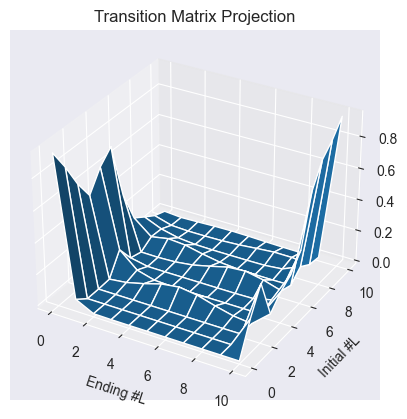

In [57]:
GraphColTM(fR = .5, LC = 1, T = 15, mF = 5, nPPL = 10)

In [58]:
def StationaryDist(LC, T, mF, nPPL, fR):
    R = nPPL * fR
    
    TM = TM = getTM(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR)
    tempTM = TM.iloc[0:len(TM),2:len(TM)+2]
    #tempTM = tempTM.div(tempTM.sum(axis=1), axis=0)
    tempTM
    mat = tempTM.to_numpy()
    mc = qe.MarkovChain(mat)     #### test if markov chain
    statdist = mc.stationary_distributions
    if mc.is_irreducible:  ## transition matrix is irreducible
        return statdist[0], TM.L, TM.C
    else: return "bruh, ur bad"

In [59]:
def CollapsedSD(LC, T, mF, nPPL, fR):
    R = nPPL * fR
    
    
    cTM = CollapsedTM(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR)
    tempcTM = cTM.iloc[0:len(cTM),1:len(cTM)+1]
    #tempTM = tempTM.div(tempTM.sum(axis=1), axis=0)
    mat = tempcTM.to_numpy()
    mc = qe.MarkovChain(mat)     #### test if markov chain
    statdist = mc.stationary_distributions
    if mc.is_irreducible:  ## transition matrix is irreducible
        return statdist[0]
    else: return "bruh, ur bad"
    
    """
    TM = TM = getTM(LC = tLC, T = tT, mF = tmF, nPPL = tnPPL, fR = tfR)
    tempTM = TM.iloc[0:len(TM),2:len(TM)+2]
    #tempTM = tempTM.div(tempTM.sum(axis=1), axis=0)
    tempTM
    mat = tempTM.to_numpy()
    mc = qe.MarkovChain(mat)     #### test if markov chain
    statdist = mc.stationary_distributions
    if mc.is_irreducible:  ## transition matrix is irreducible
        return statdist[0], TM.L, TM.C
    #    statDist, TML, TMC = StationaryDist(LC = tLC, T = tT, mF = tmF, nPPL = tnPPL, fR = tfR)
    
    sd = pd.DataFrame({'L': TML, 'C': TMC, "prob": statDist})
    csd = sd.groupby("L").sum()
    csd = csd.drop(['C'], axis = 1) #prob still sums to 1
    return csd
    """

  0%|          | 0/66 [00:00<?, ?it/s]

100%|██████████| 66/66 [00:04<00:00, 14.58it/s]


(0.0, 10.0)

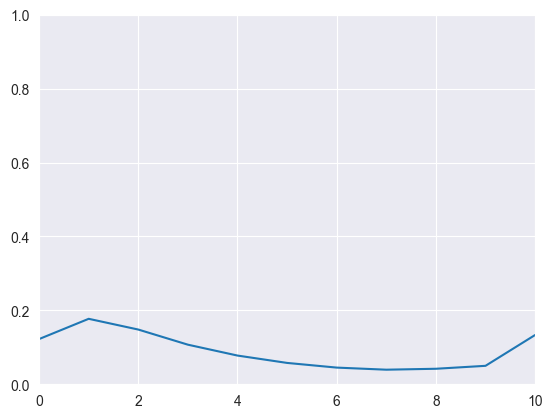

In [60]:
csd = CollapsedSD(fR = .8, LC = 1, T = 5, mF = .5, nPPL = 10)
plt.plot(csd)
plt.ylim(0,1)
plt.xlim(0,len(csd)-1)

In [61]:
csd

array([0.12234687, 0.17713251, 0.14805775, 0.10713218, 0.07770191,
       0.0577803 , 0.04513165, 0.0394531 , 0.04197579, 0.04993175,
       0.13335619])

In [62]:
def ArrItrR(LC, T, mF, nPPL, bl):

    tfR = 1 * bl  ## cannot start at 0 R
    RDis = CollapsedSD(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = tfR)
    for i in range(2,int(1/bl)+1):
        tfR = i * bl
        tR = nPPL * tfR ## .1 intervuls for Resources
        RDis = np.vstack([RDis, CollapsedSD(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = tfR)])
    return RDis

In [63]:
CollapsedSD(LC = 1, T = 15, mF = 5, nPPL = 10, fR = .5)

  0%|          | 0/66 [00:00<?, ?it/s]

100%|██████████| 66/66 [00:04<00:00, 14.76it/s]


array([7.27948306e-01, 4.37059264e-02, 2.50487801e-03, 2.15735154e-03,
       2.51969105e-03, 2.11239764e-03, 1.30441579e-03, 6.24777496e-04,
       2.70353510e-04, 1.10306953e-03, 2.15748833e-01])

In [64]:
def GraphROut(LC, T, mF, nPPL, bl):
    
    sns.set_style ("darkgrid")
    fig = plt.figure(figsize=(10,10))
    ax = Axes3D(fig)

    x = range(nPPL+1)
    y = range(int(1/bl))

    data = ArrItrR(LC = LC, T = T, mF = mF, nPPL = nPPL, bl = bl)

    hf = plt.figure()
    ha = hf.add_subplot(projection='3d')

    X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
    ha.plot_surface(X, Y, data)

    ha.set_xlabel('nLobby')
    ha.set_ylabel('R')
    ha.set_zlabel('Probability')
    ha.set_title("3D Stationary Disrobutions based on R")

    plt.show()

  0%|          | 0/66 [00:00<?, ?it/s]

100%|██████████| 66/66 [00:04<00:00, 14.92it/s]


<Figure size 1000x1000 with 0 Axes>

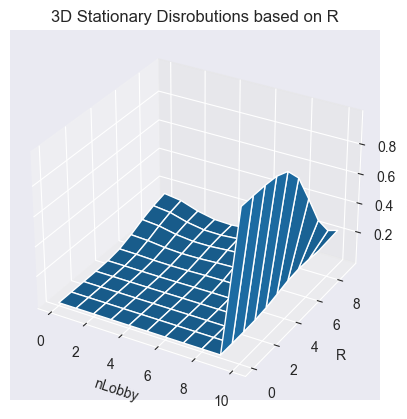

In [65]:
GraphROut(LC = 1, T = 10, mF = 1, nPPL = 10, bl = .1)